# Solar Locating Tool
### By Areeba Usman & Rose Martin

In [8]:
!pip install -q censusdata

In [9]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path
import xarray as xr
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx
import censusdata
import seaborn as sns
import requests
import zipfile
import shutil

In [15]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)
WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

In [16]:
#Code taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]



In [17]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B27001_005E': 'PopulationNoHealthInsuranceCoverage',
}

In [23]:
state_fips = '53'  # FIPS code for Washington
county_fips = '063'  # FIPS code for Spokane County

census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
census_df.head()

,Name,MedianIncome,TotalPopulation,MedianAge,PopulationBelowPovertyLevel,PopulationWhiteAlone,PopulationBlackAlone,PopulationAmericanIndianAlaskaNativeAlone,PopulationAsianAlone,PopulationNativeHawaiianPacificIslanderAlone,...,PopulationNotHispanicWhiteAlone,PopulationHispanic,MedianGrossRent,MedianHomeValue,MedianYearStructureBuilt,TotalHousingUnits,TotalVacantHousingUnits,OccupiedHousingUnitsOwnerOccupied,OccupiedHousingUnitsRenterOccupied,PopulationNoHealthInsuranceCoverage
Tract,,,,,,,,,,,,,,,,,,,,,
014500,"Census Tract 145, Spokane County, Washington",26250,1954,39.3,828,1497,142,50,20,26,...,1448,127,693,126100,1941,952,161,214,577,0
012100,"Census Tract 121, Spokane County, Washington",51223,2627,39.3,225,2464,10,53,9,0,...,2357,174,1000,161500,1958,1235,53,824,358,0
002100,"Census Tract 21, Spokane County, Washington",54620,2483,34.9,243,2174,21,57,29,43,...,2084,167,843,145500,0,1109,16,617,476,0
010301,"Census Tract 103.01, Spokane County, Washington",52531,4795,34.6,600,4518,14,35,0,51,...,4509,148,784,199000,1983,1890,115,1435,340,0
011102,"Census Tract 111.02, Spokane County, Washington",40671,4527,28.3,984,3310,374,135,100,57,...,3145,356,853,181000,1980,1732,74,457,1201,0


<Axes: >

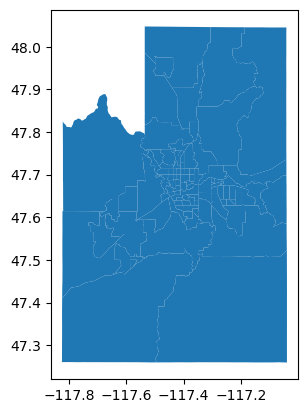

In [26]:
tract_geom_gdf.plot()